
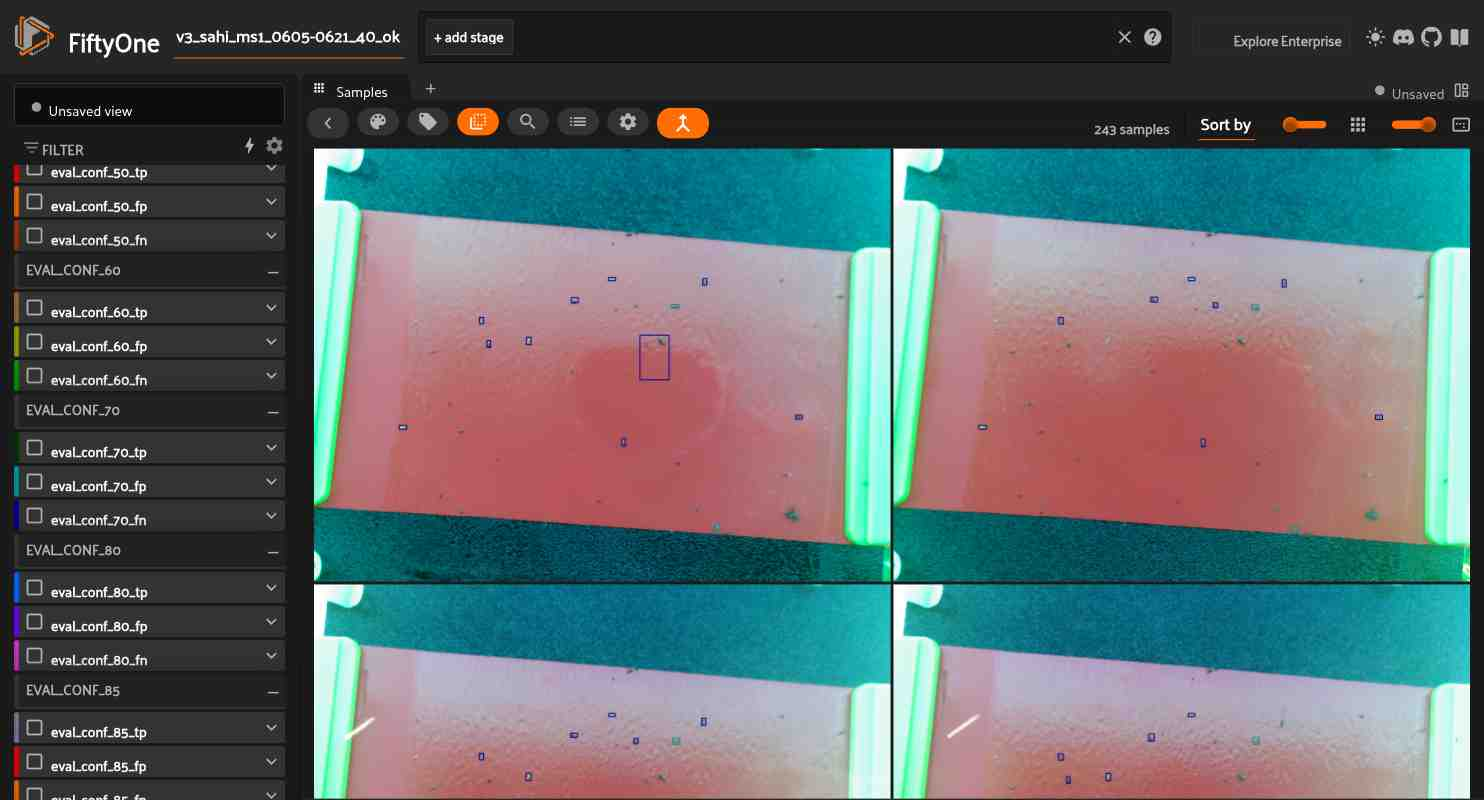

In [3]:
import fiftyone as fo  

# 加载已存在的数据集  
dataset = fo.load_dataset("my-dataset")
session = fo.launch_app(dataset)

In [ ]:
from pathlib import Path

def fetch_subsequent_dir(data_root: Path, target_subdir_name: Path):
    data_paths = list(data_root.glob(f"*/{target_subdir_name}"))
    # display(data_paths)
    # get sub dir - no target_subdir_name
    subdir_path_list = [data_path.parent for data_path in data_paths]
    # display(subdir_path_list)
    subdir_name_list = [subdir.name for subdir in subdir_path_list]
    # display(subdir_name_list)
    return subdir_path_list, subdir_name_list


# data_root = Path("/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/00_test")
data_root = Path("/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone")
version = "sahi_v1"

target_subdir_name = Path("data")
subdir_path_list, subdir_name_list = fetch_subsequent_dir(data_root, target_subdir_name)
display(subdir_path_list)
display(subdir_name_list)
len(subdir_path_list), len(subdir_name_list)

[PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms2_0726-0809_13_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/sw1_0605-0613_07_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0809-0823_34_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0710-0726_36_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0605-0621_40_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms2_0809-0823_10_ok'),
 PosixPath('/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/a02_16mp_2024_datasets_fiftyone/ms1_0726

['ms2_0726-0809_13_ok',
 'sw1_0605-0613_07_ok',
 'ms1_0809-0823_34_ok',
 'ms1_0710-0726_36_ok',
 'ms1_0605-0621_40_ok',
 'ms2_0809-0823_10_ok',
 'ms1_0726-0809_11_ok']

(7, 7)

### 使用模型推理---sahi小图

In [ ]:
from sahi import AutoDetectionModel
from sahi.predict import get_prediction, get_sliced_prediction

ckpt_path = "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/02_models/best_models/04_swd_hbb/model_v2_4datasets_noAug_seed0_yolo11s_data_split_custom_8.pt"

detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=ckpt_path,
    confidence_threshold=0.1, ## same as the default value for our base model
    image_size=640,
    device="cuda", # or 'cuda'
)

# 定义一个函数来预测切片结果
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())

In [ ]:
import fiftyone as fo  
import fiftyone.utils.coco as fouc
from pathlib import Path

count = 0
for subdir_path, subdir_name in zip(subdir_path_list, subdir_name_list):
    # 第二次退出
    # if count >= 2:
    #     break
    # count += 1
    print(f"Processing subdir: {subdir_name},{subdir_path}")
    if f"{subdir_name}_{version}" in fo.list_datasets():
        fo.delete_dataset(f"{subdir_name}_{version}") 
    dataset = fo.Dataset.from_images_dir(  
        str(subdir_path / "data"),
        name=f"{version}_{subdir_name}"  
    ) 

    # 添加COCO标签到现有数据集  
    fouc.add_coco_labels(  
        dataset,   
        label_field="ground_truth",  # 存储标签的字段名  
        labels_or_path=f"{subdir_path}/org_label_no_overlap.json",  # COCO JSON文件路径  
        categories={1: "swd"},  # 可选：类别信息，会自动从JSON中提取  
        label_type="detections"  # 标签类型：detections, segmentations, keypoints  
    )

    kwargs = {"overlap_height_ratio": 0.2, "overlap_width_ratio": 0.2}

    for sample in dataset.iter_samples(progress=True, autosave=True):
        predict_with_slicing(sample, label_field="small_slices", slice_height=640, slice_width=640, **kwargs)
    # break

In [ ]:
for subdir_path in subdir_path_list:
    print(subdir_path) 
for subdir_name in subdir_name_list:
    print(subdir_name)

In [ ]:
subdir_path_list2 = [
    "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/03_16mp_fiftyone_dataset/ms2_0726-0809_13_ok",
    "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/03_16mp_fiftyone_dataset/sw1_0605-0613_07_ok",
    # "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/03_16mp_fiftyone_dataset/ms1_0809-0823_34_ok",
    # "/home/tianqi/D/01_Projects/01_swd/02_code/pipeline/ultralytics_ty/_ty/01_data/03_16mp_fiftyone_dataset/ms1_0710-0726_36_ok",
]
subdir_name_list2 = [
    "ms2_0726-0809_13_ok_sahi_v1",
    "sw1_0605-0613_07_ok_sahi_v1",
    # "ms1_0809-0823_34_ok_sahi_v1",
    # "ms1_0710-0726_36_ok_sahi_v1",
]

# for subdir_path, subdir_name in zip(subdir_path_list2, subdir_name_list2):
#     small_slice_results = session.view.evaluate_detections("small_slices", gt_field="ground_truth", eval_key="eval_small_slices")
#     print(f"{subdir_name} Small slice results:")
#     small_slice_results.print_report()

In [ ]:
import fiftyone as fo
from fiftyone import ViewField as F

# 定义不同的置信度阈值
confidence_thresholds = [
                            0.5, 0.6, 0.7, 0.8, 0.85,
                            0.9, 0.91, 0.92, 0.93
                        ]

# for subdir_path, subdir_name in zip(subdir_path_list2, subdir_name_list2):
for subdir_path, subdir_name in zip(subdir_path_list, subdir_name_list):
    subdir_name = f"{subdir_name}_{version}"
    print(f"\n=== {subdir_name} ===")

    dataset = fo.load_dataset(subdir_name)

    print("GT 框数量:", dataset.count("ground_truth.detections"))
    print("预测框数量:", dataset.count("small_slices.detections"))


    # 创建不同置信度的视图
    views = {}
    results = {}

    for threshold in confidence_thresholds:
        views[threshold] = dataset.filter_labels(
            "small_slices", F("confidence") > threshold, only_matches=False
        )

        eval_key = f"eval_conf_{int(threshold * 100)}"
        results[threshold] = views[threshold].evaluate_detections(
            "small_slices", gt_field="ground_truth", compute_mAP=True, 
            eval_key=eval_key
        )

    # 打印比较报告
    print(f"\n{subdir_name} 详细比较:")
    print("置信度 | mAP    | 精确度 | 召回率 | 预测数")
    print("-" * 50)

    for threshold in confidence_thresholds:
        res = results[threshold]
        
        pred_count = views[threshold].count("small_slices.detections")
        print(
            f"{threshold:6.2f} | {res.mAP():6.4f} | {res.metrics()['precision']:6.4f} | {res.metrics()['recall']:6.4f} | {pred_count:6d}"
        )